In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import random 
import networkx as nx

In [2]:
KOLOR=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'gold', 'dodgerblue', 'k','pink']


In [3]:
mcolors.to_rgb(KOLOR[0])

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [4]:
len(KOLOR)

14

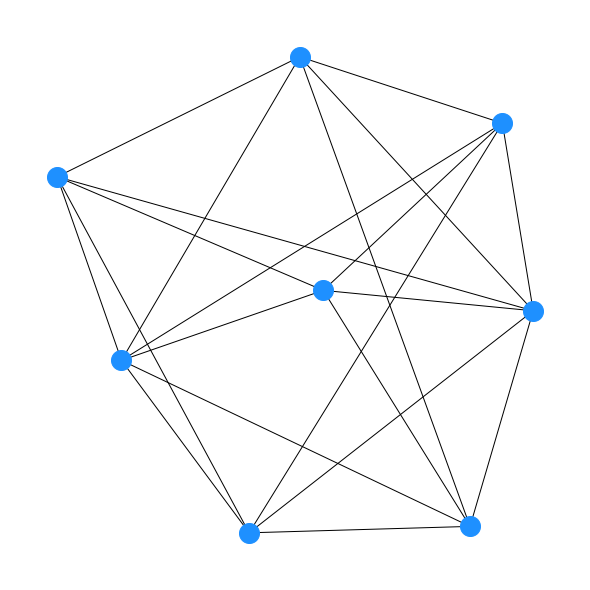

In [5]:
plt.figure(figsize=(8,8))
G = nx.turan_graph(8,3)  # 5x5 grid
pos = nx.spring_layout(G, scale=2, seed=902, iterations=100)
nx.draw(G, pos, node_color = 'dodgerblue', node_size=400)

connect={}
coordinate = {}
nodes = []
for e in G.edges:
    connect[e[0]+1,e[1]+1]=1
    nodes.append(e[0]+1)
    nodes.append(e[1]+1)
    
nodes= list(set(nodes))
N= len(nodes)
for n in G.nodes:
    coordinate[n+1,'X']=pos[n][0]
    coordinate[n+1,'Y']=pos[n][1]
plt.savefig('base_graph'+  ' .png', format='png', dpi=400)
plt.show()

In [8]:
Nc = 8
model = AbstractModel()
model.c = RangeSet(Nc)
model.i = RangeSet(N)
model.j = Set(initialize=model.i)
model.U = Var(model.i,model.c, within=Binary)
model.Z = Var(model.i,model.j,model.c,model.c, bounds=(0,1) , within=Reals)

def rule_W(model,c1,c2):
    (a1,b1,k1) = mcolors.to_rgb(KOLOR[c1])
    (a2,b2,k2) = mcolors.to_rgb(KOLOR[c2])
    return ((a1-a2)**2 + (b1-b2)**2 +(k1-k2)**2 )**0.5
model.W = Param(model.c, model.c, initialize=rule_W)

def rule_C0(model,i):
    return sum(model.U[i,c] for c in model.c) == 1
model.C0 = Constraint(model.i, rule=rule_C0)

def rule_C1(model,i,j,c1,c2):
    if (i,j) in connect and c1!=c2:
        return model.Z[i,j,c1,c2]<= model.U[i,c1]
    else:
        return Constraint.Skip    
model.C1 = Constraint(model.i,model.j, model.c,model.c, rule=rule_C1)

def rule_C2(model,i,j,c1,c2):
    if (i,j) in connect and c1!=c2:
        return model.Z[i,j,c1,c2]<= model.U[j,c2]
    else:
        return Constraint.Skip    
model.C2 = Constraint(model.i,model.j, model.c,model.c, rule=rule_C2)

def rule_C3(model,i,j,c1,c2):
    if (i,j) in connect and c1!=c2:
        return model.Z[i,j,c1,c2]>= model.U[i,c1]+model.U[j,c2] -1
    else:
        return Constraint.Skip    
model.C3 = Constraint(model.i,model.j, model.c,model.c, rule=rule_C3)
        
def rule_OF(model):
    return sum(model.W[c1,c2]* model.Z[i,j,c1,c2] for c1 in model.c for c2 in model.c for (i,j) in connect if c1!=c2 ) 
model.obj = Objective(rule= rule_OF, sense=maximize)

In [9]:
opt = SolverFactory('cbc')
instance = model.create_instance()
results = opt.solve(instance, options={"threads": 4, "rel_gap":0.1})
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)  
print(value(instance.obj))

feasible
17.84048933946597


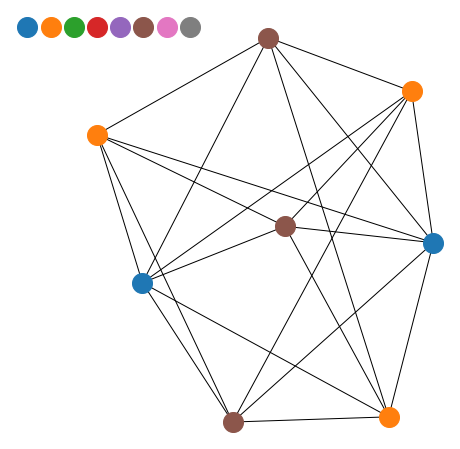

In [10]:
plt.figure(figsize=(8,8))
for (f,t) in connect:
    x1= coordinate[f,'X']
    y1= coordinate[f,'Y']
    x2= coordinate[t,'X']
    y2= coordinate[t,'Y']
    plt.plot([x1,x2],[y1,y2], '-',lw=1, color= 'k', zorder= -1)
for i in instance.i:
    x1= coordinate[i,'X']
    y1= coordinate[i,'Y']
    cindex= int(sum(value(instance.U[i,c])*c for c in instance.c))
    plt.scatter(x1,y1,s=400, color= KOLOR[cindex-1], zorder= 2)
    
for c in instance.c:
    plt.scatter(-3+ 0.25*c,2,s=400, color= KOLOR[c-1], zorder= 2)
plt.axis('off')
plt.savefig('Max distance Coloring'+  ' .png', format='png', dpi=400)